In [55]:
# Chapter1
# NN構築試行
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score  # モデルの評価を行うための関数
from keras import metrics


pd.set_option("max_columns", 200)
pd.set_option('max_rows', None)
# 学習データ読み込み
data_X = pd.read_csv("train2.csv")
# data = data_X.dropna(how="any")
# data_X.fillna("", inplace=True)
data = data_X
data.head()

,Unnamed: 0,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y,house_price
0,0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0,496059
1,1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,100%,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0,603443
2,2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,100%,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0,743962
3,3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,100%,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0,1440449
4,4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,100%,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0,1287128


In [62]:
from sklearn.model_selection import train_test_split
import optuna

# Chapter3
# データ前処理
feature_nums = ["accommodates","bathrooms","bedrooms","beds","latitude","longitude","number_of_reviews","review_scores_rating", "house_price"]
feature_obj = ["amenities","bed_type","cancellation_policy","city","cleaning_fee","description","first_review","host_has_profile_pic","host_identity_verified","host_response_rate","host_since","instant_bookable","last_review","name","neighbourhood","property_type","room_type","thumbnail_url","zipcode"]

def pre_process(input_data_X: pd.DataFrame):
    # temp_data = input_data_X.drop("amenities", axis=1)
    temp_data = input_data_X

    for feature in feature_nums:
        if feature in temp_data:
            temp_data[feature].fillna(temp_data[feature].mode(), inplace=True)
    for feature in feature_obj:
        if feature in temp_data:
            temp_data[feature].fillna("", inplace=True)
    
    processed_X = pd.get_dummies(temp_data.drop(["Unnamed: 0", "id", "amenities","description","zipcode"], axis=1))
    return processed_X
train_dataset = pre_process(data)

y_raw = train_dataset["y"]
X_raw = train_dataset.drop(["y"], axis=1)



In [57]:
# import optuna
# from sklearn.metrics import mean_squared_error

# def objective(trial):
#     X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2)

#     # パラメータの指定
#     params = {
#         'iterations': trial.suggest_int('iterations', 1000, 3000),                         
#         'depth': trial.suggest_int('depth', 4, 10),                                       
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
#         'random_strength': trial.suggest_int('random_strength', 0, 100),                       
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
#         'od_wait': trial.suggest_int('od_wait', 10, 50),
#         'loss_function': trial.suggest_categorical("loss_function", ["RMSE", "MultiRMSE", "MAE", "Quantile", "LogLinQuantile", "Poisson", "MAPE"])

#     }
#     model = CatBoostRegressor(**params)

#     categorical_features_indices_train = np.where(X_train.dtypes != np.float)[0]
#     c_train = Pool(X_train, label=y_train, cat_features=categorical_features_indices_train)  

#     model.fit(c_train, verbose=False)

#     c_test = Pool(X_test, cat_features=categorical_features_indices_train)
#     y_proba = model.predict(c_test)

#     rmse_score = np.sqrt(mean_squared_error(y_test, y_proba))
#     return rmse_score

In [58]:
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [59]:
# params = study.best_params

# # params = {'iterations': 2000, 'depth': 5, 'learning_rate': 0.21681003763345277, 'random_strength': 47, 'bagging_temperature': 0.08550747765748958, 'od_wait': 44, 'loss_function': 'RMSE'}

In [63]:
import lightgbm as lgb #LightGBM

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw,test_size=0.2)

# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': 'rmse' # 評価指標 : rsme(平均二乗誤差の平方根) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# # テストデータの予測
y_pred = model.predict(X_test)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 74
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 160.750911
[1]	valid_0's rmse: 157.68
[2]	valid_0's rmse: 150.908
[3]	valid_0's rmse: 145.301
[4]	valid_0's rmse: 140.493
[5]	valid_0's rmse: 136.347
[6]	valid_0's rmse: 132.701
[7]	valid_0's rmse: 129.705
[8]	valid_0's rmse: 126.839
[9]	valid_0's rmse: 124.494
[10]	valid_0's rmse: 122.644
[11]	valid_0's rmse: 120.906
[12]	valid_0's rmse: 119.414
[13]	valid_0's rmse: 118.13
[14]	valid_0's rmse: 116.956
[15]	valid_0's rmse: 116.15
[16]	v

In [65]:

from sklearn.metrics import mean_squared_error # モデル評価
from sklearn.metrics import mean_absolute_error
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE :',mae)


RMSE : 106.28652917082
MAE : 52.01984329224173


In [54]:
# X_data = pd.read_csv("test2.csv")

# X_test = pre_process(X_data)

# categorical_features_indices_test = np.where(X_test.dtypes != np.float)[0]
# c_test = Pool(X_test, cat_features=categorical_features_indices_test)  
# y_proba = model.predict(c_test)

NameError: name 'Pool' is not defined

In [141]:
# np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\\result.dat", y_proba.astype("float"), fmt="%0.10f",)

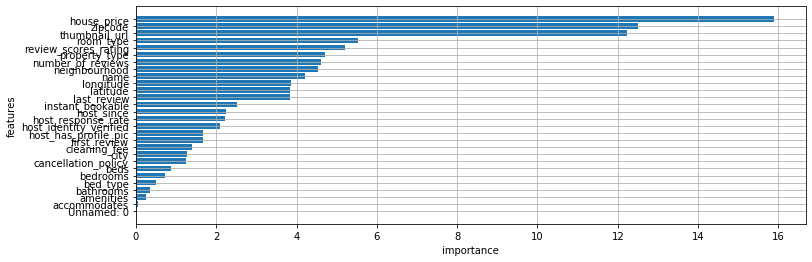

In [142]:
from matplotlib import pyplot as plt
from sklearn import datasets
# 特徴量の重要度を取得する
feature_importance = model.get_feature_importance()
feature_importance.sort()
# 棒グラフとしてプロットする
plt.figure(figsize=(12, 4))
plt.barh(range(len(feature_importance)),
        feature_importance,
        tick_label=X_raw.keys())

plt.xlabel('importance')
plt.ylabel('features')
plt.grid()
plt.show()

In [143]:
feature_importance.sort()
feature_importance

array([ 0.        ,  0.06326435,  0.25035982,  0.3395601 ,  0.49863814,
        0.71484515,  0.87254306,  1.23750785,  1.26769531,  1.40631941,
        1.66504008,  1.68084908,  2.09138543,  2.20852624,  2.25418575,
        2.50730758,  3.83149012,  3.84525728,  3.85232929,  4.20223852,
        4.54312891,  4.60355624,  4.7189045 ,  5.20190551,  5.52916933,
       12.21798473, 12.51375443, 15.88225376])

In [144]:
X_raw["accommodates"].head()

0    6
1    2
2    2
3    2
4    2
Name: accommodates, dtype: int64